Features: Year + Total
# Intro

Consider a model with 2 features

$$
f(t) = f_1(t_1)+f_2(t_2),\\
f_1\sim GP(0, K1), \\
f_2\sim GP(0, K2)
$$
where $t_1\in[0,1]$ and $t_2\in[0,1]$, and while $t_1$ corresponds to observed rescaled time, $t_2$ is within 1 regularised year (52 weeks). We will model both with squared exponential GPs.

**Outcome:**
1. Should standardise responses really
2. Should add more features: 
3. Need get rid of outliers: try stumpy


In [22]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import pandas as pd

from functools import partial

In [2]:
import jax
from jax import vmap, jit

In [3]:
import jax.numpy as np
import jax.random as random

In [4]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

In [5]:
# FROM LOCAL FILES
import os
import sys

from jax.scipy.linalg import cholesky

path_project_modules = os.path.join('modules')
sys.path.insert(1, path_project_modules)

from GP import predictGP, uncrt, sq_exp, cov_map

# Constants

In [6]:
dt_year = 0.11070559610705594
dt_trimester = 0.03690186536901865

# Funs

In [99]:
def model2(X1, Y):
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var1 = numpyro.sample("kernel_var1", dist.LogNormal(0.0, 10.0))
    noise1 = numpyro.sample("kernel_noise1", dist.LogNormal(0.0, 10.0))
    length1 = numpyro.sample("kernel_length1", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k1 = kernel(X1, X1, var1, length1, noise1)

    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var2 = numpyro.sample("kernel_var2", dist.LogNormal(0.0, 10.0))
    noise2 = numpyro.sample("kernel_noise2", dist.LogNormal(0.0, 10.0))
    length2 = numpyro.sample("kernel_length2", dist.LogNormal(0.0, 10.0))

    # compute kernel
    X2 = X1/dt_year-(X1//dt_year)
    k2 = kernel(X2, X2, var2, length2, noise2)

    
    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=k1+k2),
        obs=Y,
    )

In [55]:
kernel = lambda X1, X2, var, length, noise, include_noise = True: \
    cov_map(partial(sq_exp, l = length, v = var), X, X)\
    +np.eye(X1.shape[0])*(noise+1e-6)*include_noise

In [45]:
def model2a(X1, Y):
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var1 = numpyro.sample("kernel_var1", dist.LogNormal(0.0, 10.0))
    noise1 = numpyro.sample("kernel_noise1", dist.LogNormal(0.0, 10.0))
    length1 = numpyro.sample("kernel_length1", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k1 = kernel(X1, X1, var1, length1, noise1)

    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var2 = numpyro.sample("kernel_var2", dist.LogNormal(0.0, 10.0))
    noise2 = numpyro.sample("kernel_noise2", dist.LogNormal(0.0, 10.0))
    length2 = numpyro.sample("kernel_length2", dist.LogNormal(0.0, 10.0))

    # compute kernel
    X2 = X1/dt_year-(X1//dt_year)
    k2 = kernel(X2, X2, var2, length2, noise2)

    N = Y.size
    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y",
       dist.TransformedDistribution(dist.Normal().expand([N]),
                                    dist.transforms.LowerCholeskyAffine(np.zeros(N),
                                                                        np.linalg.cholesky(k1+k2))), 
       obs = Y)

In [72]:
def model_predict(key, x, y, t, var1, length1, noise1, var2, length2, noise2):

    m1, k1 = predictGP(x, y,
              t, 
              partial(sq_exp, l = length1, v = var1), 
              noise1)

    
    x2 = x/dt_year-(x//dt_year)
    t2 = t/dt_year-(t//dt_year)
    
    m2, k2 = predictGP(x2, y,
              t2, 
              partial(sq_exp, l = length2, v = var2), 
              noise2)

    key1, key2 = random.split(key)
    
    dm1 = uncrt(key1, m1, k1)
    dm2 = uncrt(key2, m2, k2)
    
    return m1+m2, dm1+dm2

In [53]:
# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict2(rng_key, X1, Y, X_test1, var1, length1, noise1, var2, length2, noise2):
    # compute kernels between train and test data, etc.
    # k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    # k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    # k_XX = kernel(X, X, var, length, noise, include_noise=True)
    # K_xx_inv = np.linalg.inv(k_XX)
    # K = k_pp - np.matmul(k_pX, np.matmul(K_xx_inv, np.transpose(k_pX)))
    
    def comp_ker(rng_key, X, Y, X_test, var, length, noise):
        k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
        k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
        k_XX = kernel(X, X, var, length, noise, include_noise=True)
        
        return k_pp, k_pX, k_XX
    
    k_pp1, k_pX1, K_XX1 = comp_ker(rng_key, X1, Y, X_test1, var1, length1, noise1)
    
    X2 = X1/dt_year-(X1//dt_year)
    X_test2 = X_test1/dt_year-(X_test1//dt_year)
    k_pp2, k_pX2, K_XX2 = comp_ker(rng_key, X2, Y, X_test2, var2, length2, noise2)
    
    
    K_xx_inv = np.linalg.inv(K_XX1+K_XX2)
        
    K = k_pp1+k_pp2 - np.matmul(k_pX1+k_pX2, np.matmul(K_xx_inv, np.transpose(k_pX1+k_pX2)))
    mean = np.matmul(k_pX1+k_pX2, np.matmul(K_xx_inv, Y))
    
    
    sigma_noise = np.sqrt(np.clip(np.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test1.shape[:1])
    
    
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [9]:
# helper function for doing hmc inference
def run_inference(model, args, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if args['init_strategy'] == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif args['init_strategy'] == "median":
        init_strategy = init_to_median(num_samples=10)
    elif args['init_strategy'] == "feasible":
        init_strategy = init_to_feasible()
    elif args['init_strategy'] == "sample":
        init_strategy = init_to_sample()
    elif args['init_strategy'] == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args['num_warmup'],
        num_samples=args['num_samples'],
        num_chains=args['num_chains'],
        thinning=args['thinning'],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()

In [10]:
# load csv
df = pd.read_csv('Data/Ozone_time_series.csv')
df;

In [50]:
# X = df['reg_year_dtab'].to_numpy()[::5]
X = df['dtab'].to_numpy()[::10]


Y = df['x'].to_numpy()[::10]
Y = (Y-Y.mean())/Y.std()



X_test = np.linspace(0., 1., 300)
# X_test = X

X2 = X/dt_year-(X//dt_year)
X_test2 = X_test/dt_year-(X_test//dt_year)

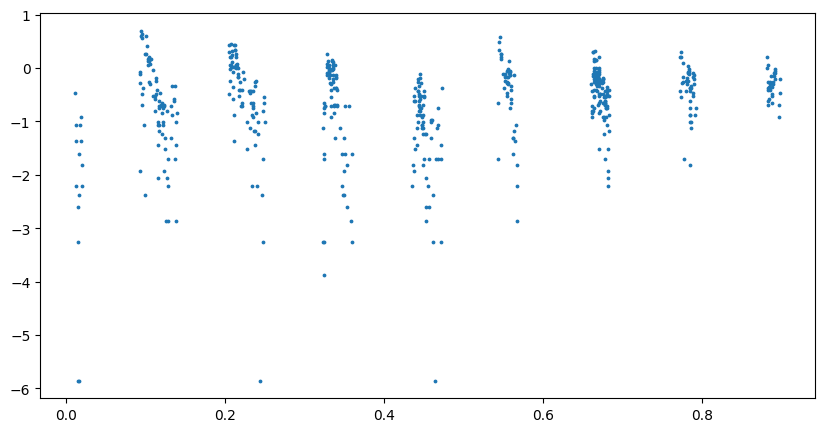

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(X, np.log(Y), 3)

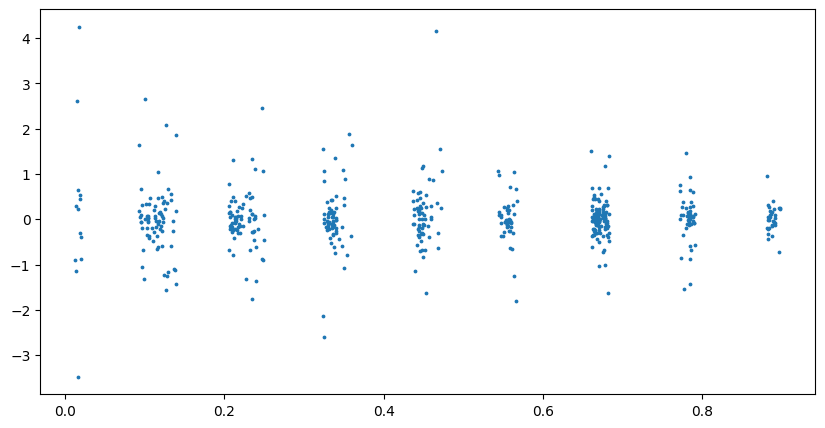

In [217]:
plt.figure(figsize=(10, 5))
plt.scatter(X[1:], np.diff(np.log(Y)), 3)

In [48]:
X.shape, Y.shape

((565,), (565,))

In [51]:
%%time
args = {'init_strategy': 'feasible', 
        'num_samples': 1000, 
        'num_warmup': 100, 
        'num_chains': 1,
        'device': 'cpu',
        'thinning': 2,
        }

rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model2a, args, rng_key, X, Y)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 10 µs


sample: 100%|█| 1100/1100 [07:04<00:00,  2.59it/s, 63 steps of size 4.53e-02. ac



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length1      0.00      0.00      0.00      0.00      0.00    420.99      1.00
  kernel_length2      0.01      0.00      0.01      0.01      0.01    402.26      1.00
   kernel_noise1      0.02      0.02      0.03      0.00      0.05    149.38      1.00
   kernel_noise2      0.02      0.02      0.01      0.00      0.05    147.61      1.00
     kernel_var1      0.10      0.02      0.09      0.07      0.12    516.31      1.00
     kernel_var2      0.83      0.24      0.79      0.48      1.14    287.60      1.01

Number of divergences: 0

MCMC elapsed time: 426.92693185806274


In [202]:
samples['kernel_length1'].mean(), samples['kernel_length2'].mean()

(DeviceArray(0.00133089, dtype=float32),
 DeviceArray(0.10346517, dtype=float32))

In [52]:
samples['kernel_length1'].mean(), samples['kernel_length2'].mean()

(DeviceArray(0.00110681, dtype=float32),
 DeviceArray(0.01009475, dtype=float32))

In [65]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    """
    Return covariance matrix of size X x Z
    """
    deltaXsq = np.power((X[:, None] - Z) / length, 2.0) # raise matrix X-Z to power 2.0
    k = var * np.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * np.eye(X.shape[0])
    return k

In [63]:
kernel = lambda X1, X2, var, length, noise, include_noise = True: \
    cov_map(partial(sq_exp, l = length, v = var), X1, X2)\
    +np.eye(X1.shape[0])*(noise+1e-6)*include_noise

In [66]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var1"].shape[0]),
     samples["kernel_var1"],
     samples["kernel_length1"],
     samples["kernel_noise1"],
     samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"],
)
means, predictions = vmap(
    lambda rng_key, var1, length1, noise1, var2, length2, noise2: predict2(
        rng_key, X, Y, X_test, var1, length1, noise1, var2, length2, noise2
    )
)(*vmap_args)

mean_prediction = onp.mean(means, axis=0)
percentiles = onp.percentile(predictions, [5.0, 95.0], axis=0)

CPU times: user 18.2 s, sys: 10.1 s, total: 28.3 s
Wall time: 7.4 s


In [73]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var1"].shape[0]),
     samples["kernel_var1"],
     samples["kernel_length1"],
     samples["kernel_noise1"],
     samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"],
)
means1, predictions1 = vmap(
    lambda rng_key, var1, length1, noise1, var2, length2, noise2: model_predict(
        rng_key, X, Y, X_test, var1, length1, noise1, var2, length2, noise2
    )
)(*vmap_args)

mean_prediction1 = onp.mean(means1, axis=0)
percentiles1 = onp.percentile(predictions1, [5.0, 95.0], axis=0)

CPU times: user 30.7 s, sys: 13.4 s, total: 44.1 s
Wall time: 11.3 s


In [207]:
%%time

# do prediction
vmap_args = (
    random.split(rng_key_predict, samples["kernel_var1"].shape[0]),
     samples["kernel_var1"],
     samples["kernel_length1"],
     samples["kernel_noise1"],
     samples["kernel_var2"],
     samples["kernel_length2"],
     samples["kernel_noise2"],
)
means, predictions = vmap(
    lambda rng_key, var1, length1, noise1, var2, length2, noise2: predict2(
        rng_key, X, Y, X, var1, length1, noise1, var2, length2, noise2
    )
)(*vmap_args)

mean_prediction1 = onp.mean(means, axis=0)
percentiles1 = onp.percentile(predictions, [5.0, 95.0], axis=0)

CPU times: user 2min 24s, sys: 2min 17s, total: 4min 41s
Wall time: 1min 15s


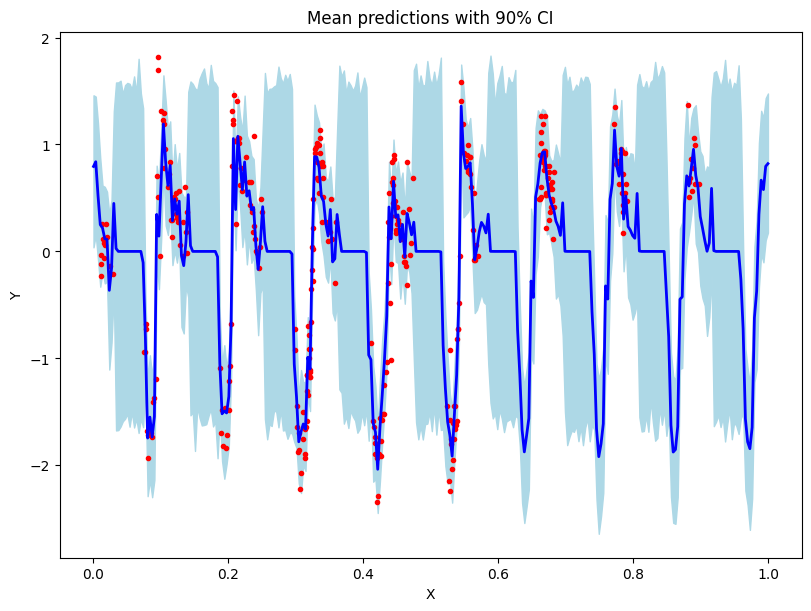

In [69]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, ".r")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

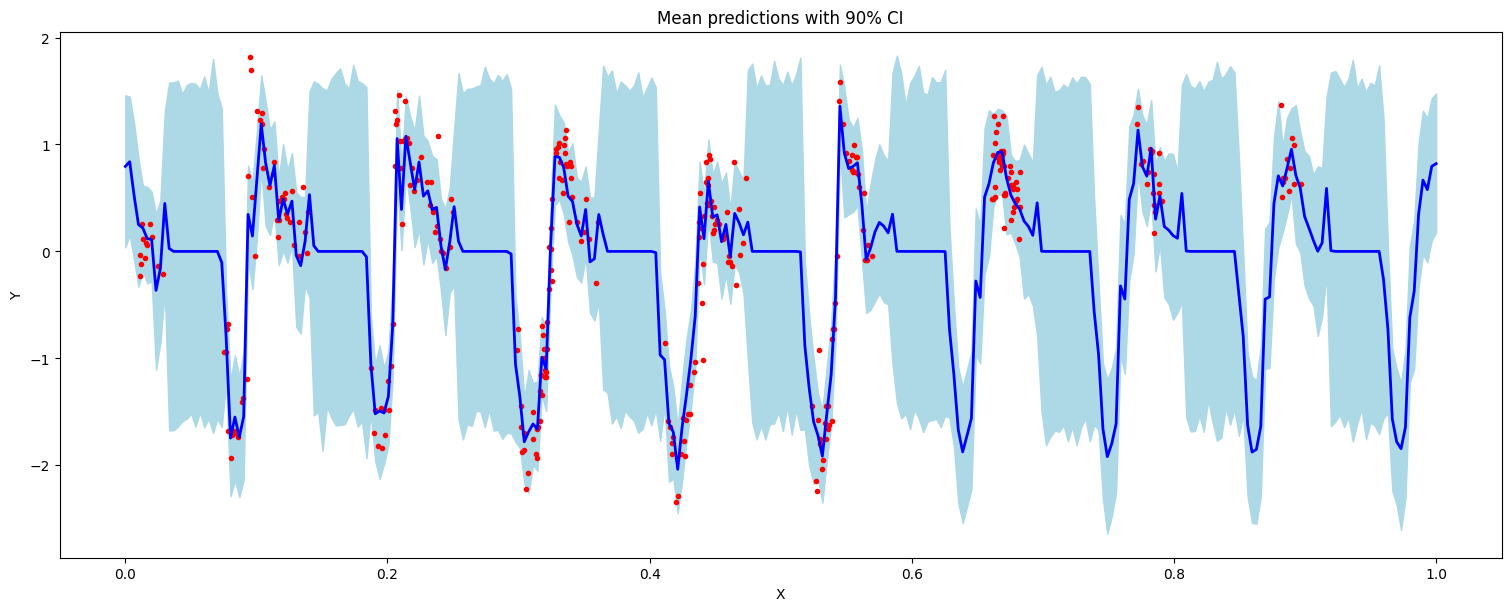

In [68]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

# plt.ylim([-400, 600])

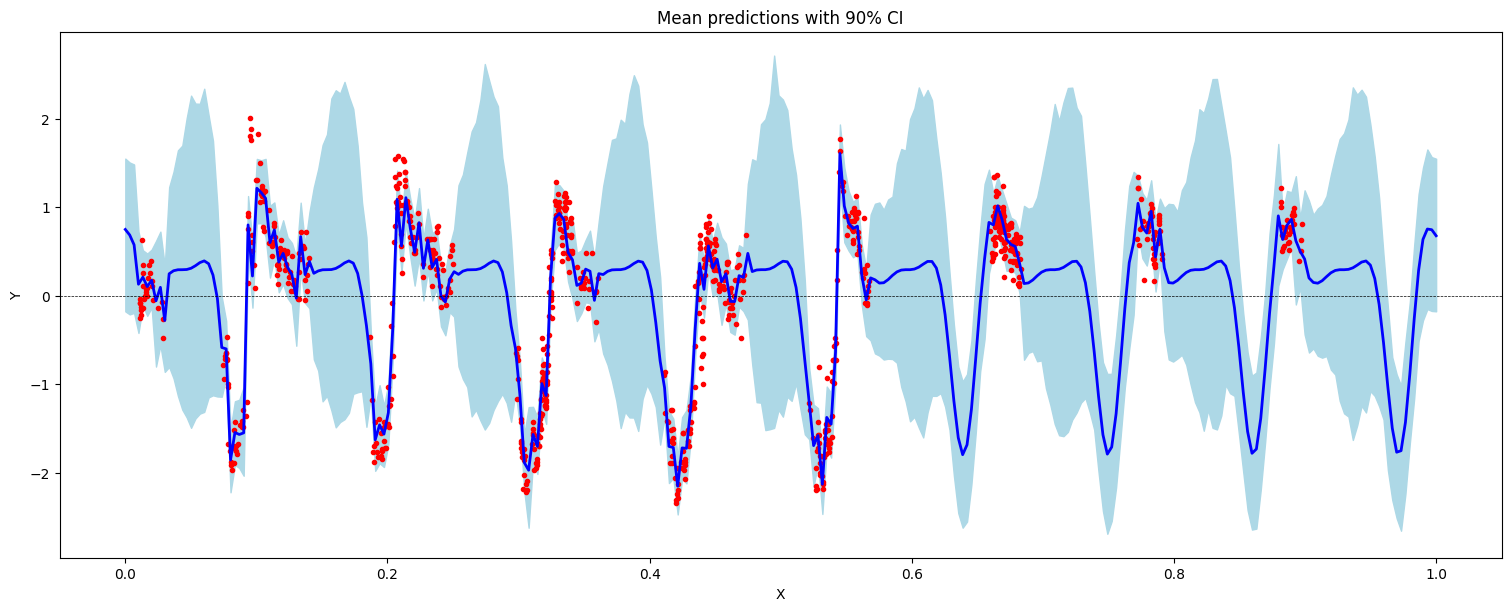

In [208]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "r.")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

ax.axhline(0, linestyle = '--', color = 'k', linewidth = '.5')

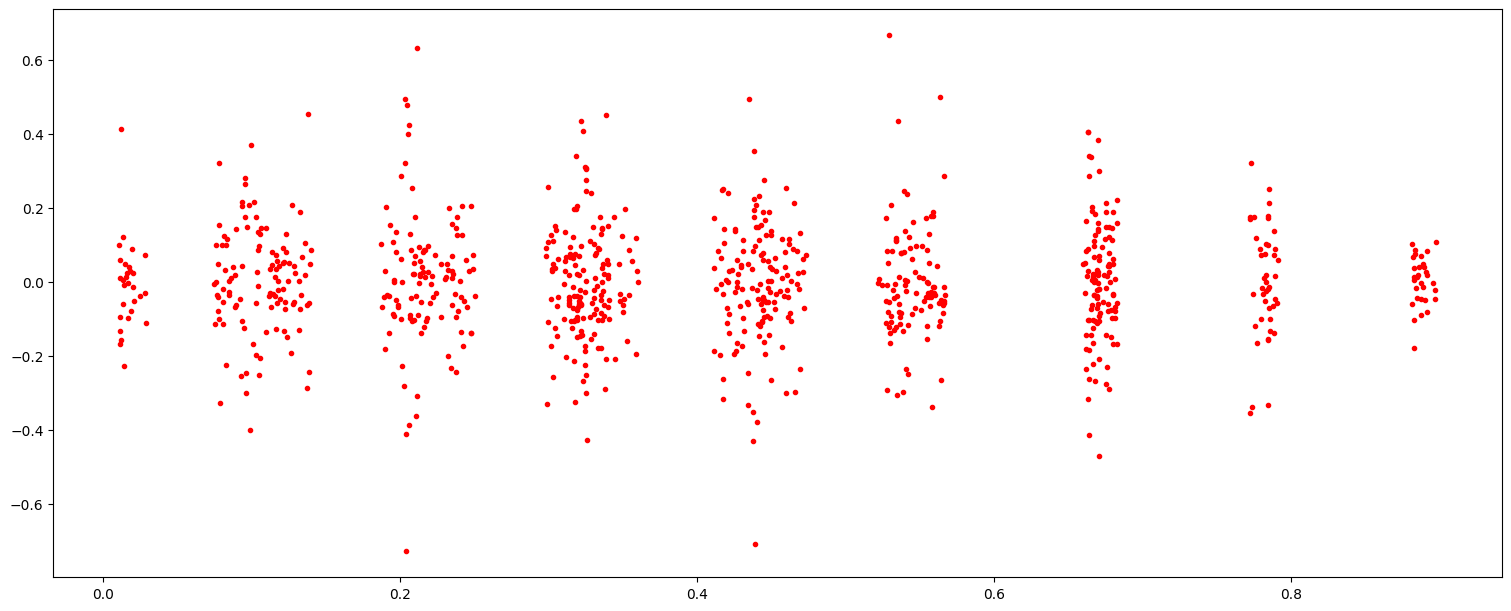

In [209]:
# make plots
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y-mean_prediction1, "r.")
# plot 90% confidence level of predictions
# ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
# ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)

In [210]:
np.mean(Y-mean_prediction1), np.std(Y-mean_prediction1), 

(DeviceArray(-1.2724817e-05, dtype=float32),
 DeviceArray(0.15317681, dtype=float32))